# Location of the dataset in the Google Drive

### 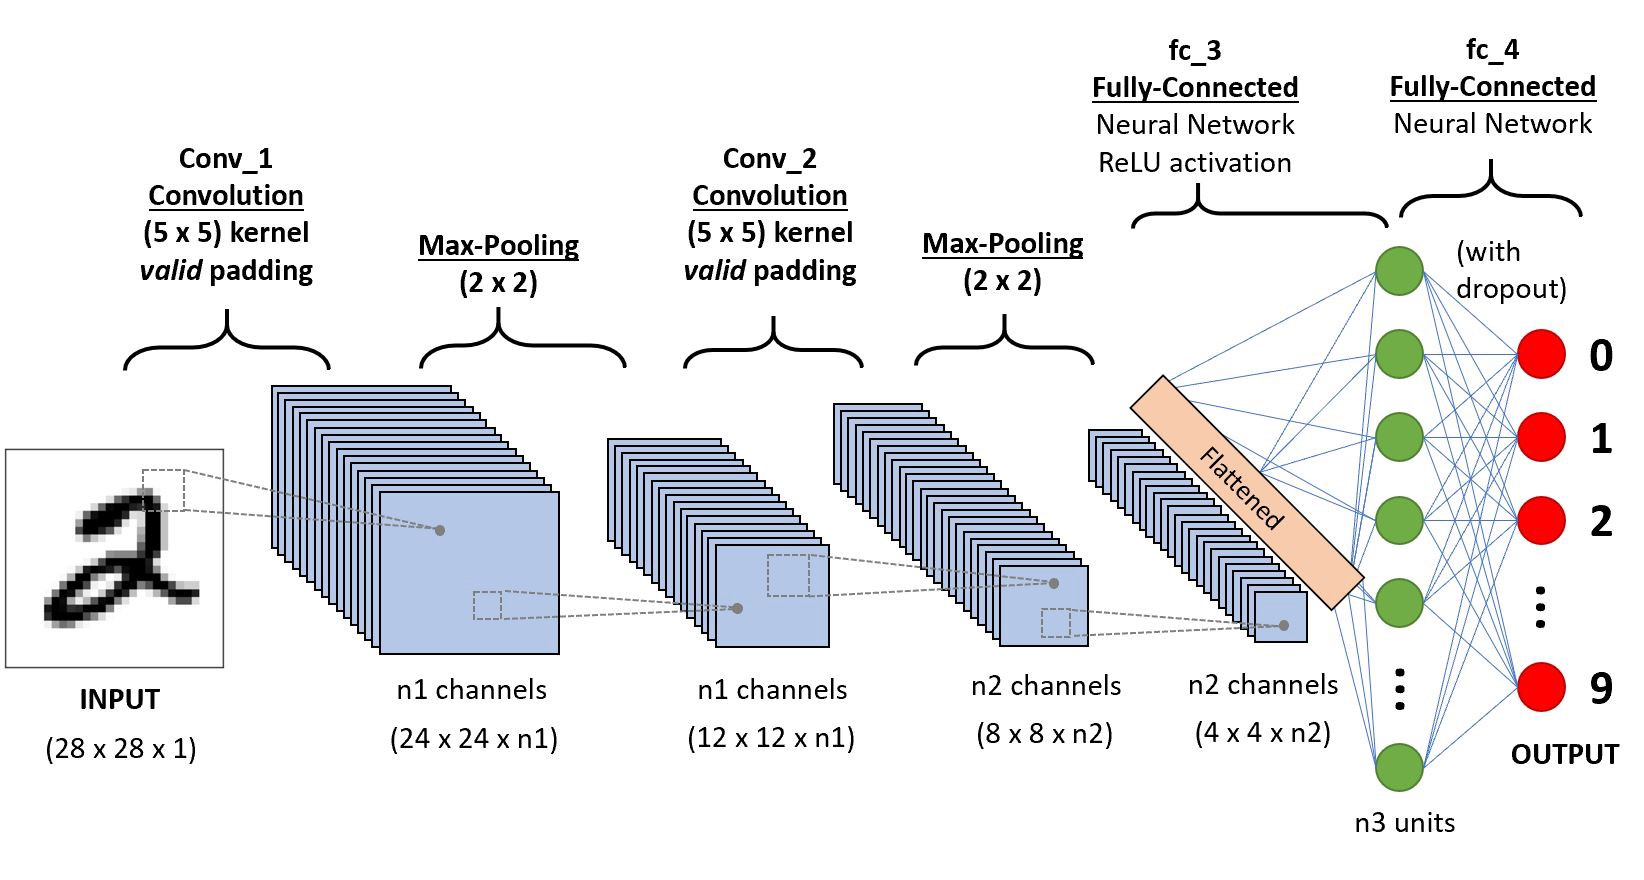




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install google.colab

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement google.colab (from versions: none)
ERROR: No matching distribution found for google.colab

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# /content/drive/MyDrive/deepfake/realvsfakeus

# Installing the required libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve, PrecisionRecallDisplay

## Setting the image fixed size for training and intializing the batch size, channel and number of epochs

In [ ]:
Image_Size= 256
Batch_Size = 32
Channels=3

## Determining number of pics and classes

In [ ]:
imgdata = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/deepfake/realvsfakeus",
    shuffle=True,
    image_size = (Image_Size,Image_Size),
    batch_size=Batch_Size

)

Found 2059 files belonging to 2 classes.


## This code creates a dataset of images using the Keras utility function image_dataset_from_directory.

### It reads images from a specified directory and organizes them into batches for training or validation.

### Here’s what each parameter means:


1.   This is the path to the directory containing your image data.
2.   The function will look for subdirectories within this path, where each subdirectory corresponds to a different class or label (e.g., “real” and “fake” faces).
3. Images in each subdirectory will be treated as examples of that class.












In [ ]:
class_names = imgdata.class_names
class_names  # 0 means fake and 1 means real

['fake', 'real']

## The below code iterates over the first batch of data from the dataset.
1. The take(1) method ensures that only one batch is retrieved.
2. Each batch contains a set of images and their corresponding labels.
3. The .numpy() method converts the labels from TensorFlow tensors to NumPy arrays for easier printing.
4. The labels correspond to the class names (“fake” or “real”) associated with each image

In [ ]:
for image_batch, label_batch in imgdata.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 1 0 0 0 0 0 1 1 0 1 1 1 0 0 0 1 0 1 0 0 1 0 1 1 1 1 0 1 0 1]


## Displaying our first image

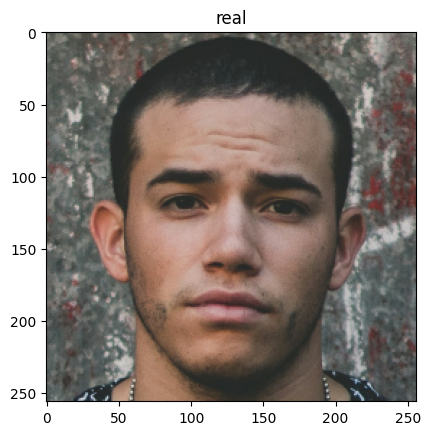

In [ ]:
for image_batch, label_batch in imgdata.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])

# Function to split dataset

In [ ]:
def splitting_dataset_tf(ds, train_split=0.7, val_split=0.15, test_split=0.15, shuffle=True, shuffle_size=10000):

    ds_size=len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size=int(train_split * ds_size)
    val_size= int(val_split * ds_size)

    train_ds= ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds=splitting_dataset_tf(imgdata)

In [ ]:
print(len(train_ds),len(val_ds),len(test_ds))

52 6 7


#  Pipeline for Optimization for Training, Validation, and Testing Datasets

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Image Preprocessing for Resizing and Rescaling

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(Image_Size,Image_Size),
    tf.keras.layers.Rescaling(1.0/255)
])

# Data augmentation

In [ ]:
data_aug = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),

])

# Architecture of the model


1. input_shape: This defines the format of the input image data. It specifies a batch size, image size (height and width), and number of channels (usually 3 for RGB images).
2. n_classes: This indicates the number of output classes the model will predict. In this case, there are 3 classes, likely representing "real", "fake", and potentially an "uncertain" category.

### Model Layers:
1. The model uses a sequential architecture, stacking layers one after another:
2. resize_and_rescale (function not shown): This likely preprocesses the input images by resizing them to a standard size and potentially rescaling the pixel values.
3. data_aug (function not shown): This might be for data augmentation, which involves creating variations of the original images (e.g., flips, rotations) to improve the model's ability to generalize.
4. Convolutional Layers: These layers extract features from the image. There are six convolutional layers, each with:
5. 32 or 64 filters: These filters learn to detect specific patterns in the image.
6. Kernel size of (3,3): This defines the size of the area the filter scans over the image.
7. relu activation: This adds non-linearity to the model's predictions.
8. Pooling Layers: These layers reduce the dimensionality of the data and potentially capture higher-level features. There are six max pooling layers, each with a kernel size of (2,2).
9. Flatten Layer: This transforms the 2D feature maps from the convolutional layers into a 1D vector.
10. Dense Layers: These are fully-connected layers that learn more complex relationships between the features.
11. First dense layer has 64 units with relu activation.
12. Second dense layer has n_classes units (likely 3) with softmax activation. Softmax ensures the output probabilities for all classes sum to 1



In [ ]:
input_shape = (Batch_Size,Image_Size, Image_Size,Channels)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_aug,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),


    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation= 'softmax'),

])

model.build(input_shape=input_shape)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Compiling the model with loss function and optimizer


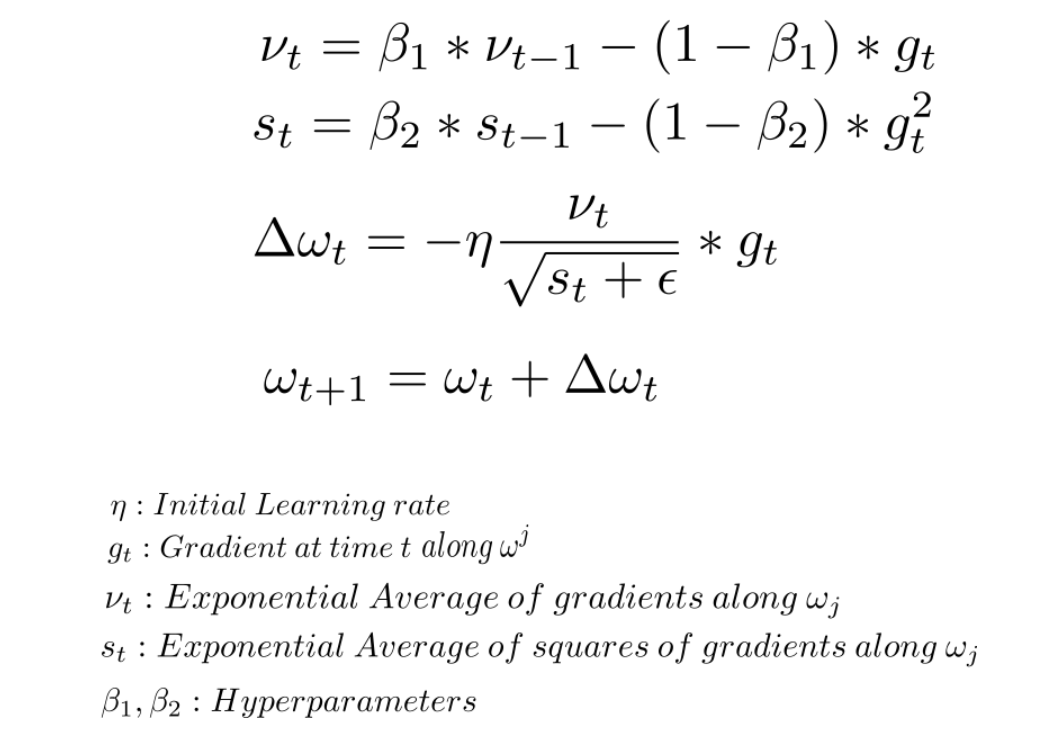

In [ ]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Model Training with Training and Validation Data

In [ ]:
history = model.fit(
    train_ds,
    epochs=275,
    batch_size=Batch_Size,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/275
52/52 ━━━━━━━━━━━━━━━━━━━━ 173s 101ms/step - accuracy: 0.5184 - loss: 0.7791 - val_accuracy: 0.5399 - val_loss: 0.7138
Epoch 2/275
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.5091 - loss: 0.7045 - val_accuracy: 0.5216 - val_loss: 0.6922
Epoch 3/275
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.5190 - loss: 0.6954 - val_accuracy: 0.5393 - val_loss: 0.7016
Epoch 4/275
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.5355 - loss: 0.6944 - val_accuracy: 0.5399 - val_loss: 0.6925
Epoch 5/275
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.5296 - loss: 0.6950 - val_accuracy: 0.4607 - val_loss: 0.7001
Epoch 6/275
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.5170 - loss: 0.6945 - val_accuracy: 0.5399 - val_loss: 0.7029
Epoch 7/275
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.5297 - loss: 0.6991 - val_accuracy: 0.5393 - val_loss: 0.6893
Epoch 8/275
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.5197 - loss: 0.6925 - val_accuracy:

# Model Accuracy and Model Loss

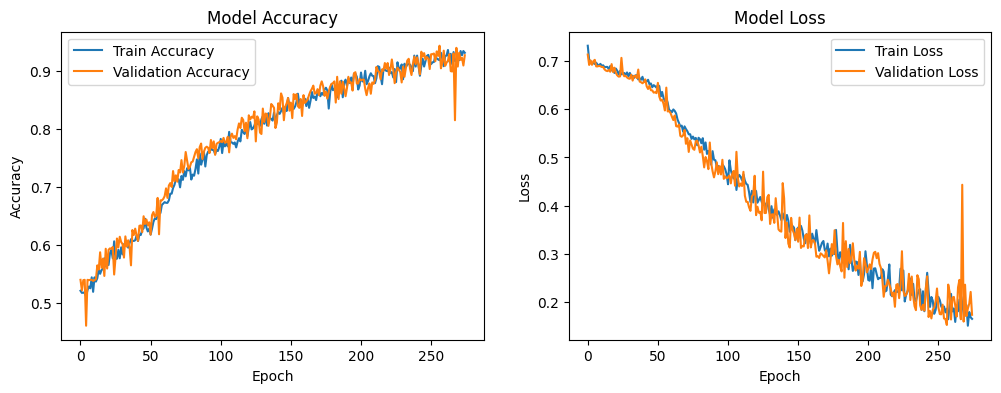

In [ ]:
# Plot model accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plot model loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()


In [ ]:
import plotly.graph_objs as go

# Interactive Accuracy Plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(len(history.history['accuracy']))),
                         y=history.history['accuracy'],
                         mode='lines',
                         name='Train Accuracy'))
fig.add_trace(go.Scatter(x=list(range(len(history.history['val_accuracy']))),
                         y=history.history['val_accuracy'],
                         mode='lines',
                         name='Validation Accuracy'))
fig.update_layout(title='Model Accuracy',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')
fig.show()

# Interactive Loss Plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(len(history.history['loss']))),
                         y=history.history['loss'],
                         mode='lines',
                         name='Train Loss'))
fig.add_trace(go.Scatter(x=list(range(len(history.history['val_loss']))),
                         y=history.history['val_loss'],
                         mode='lines',
                         name='Validation Loss'))
fig.update_layout(title='Model Loss',
                  xaxis_title='Epoch',
                  yaxis_title='Loss')
fig.show()


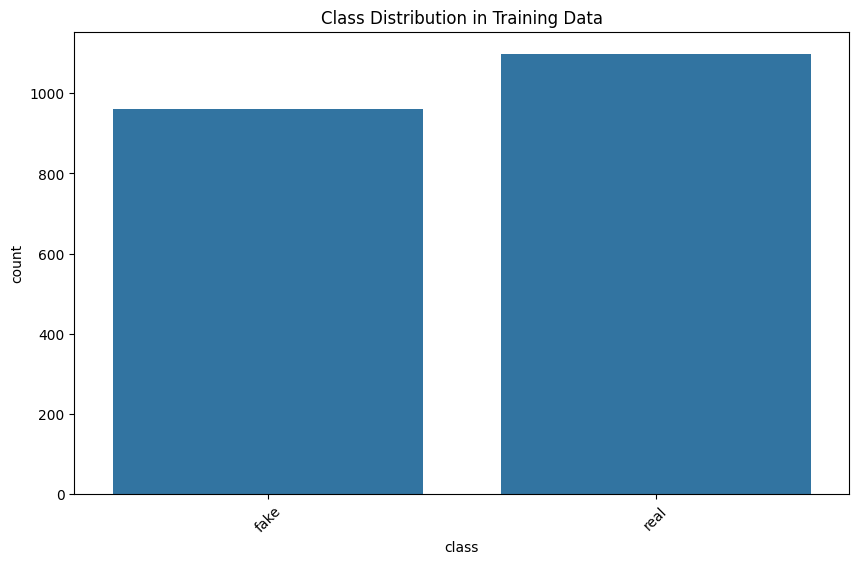

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame from the training dataset
class_names = imgdata.class_names
labels = []

for images, label_batch in imgdata:
    labels.extend(label_batch.numpy())

# Create a DataFrame
train_data = pd.DataFrame({'class': [class_names[label] for label in labels]})

# Plot class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='class', data=train_data)
plt.title('Class Distribution in Training Data')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Collect images and labels into lists
all_images = []
all_labels = []

for images, labels in test_ds:
    all_images.extend(images.numpy())
    all_labels.extend(labels.numpy())

# Convert lists to arrays for easier indexing
all_images = np.array(all_images)
all_labels = np.array(all_labels)


<ipython-input-57-24dd033a4f6b>:1: DeprecationWarning:

Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.



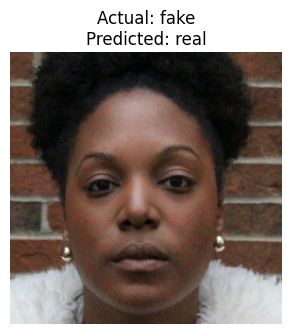

In [ ]:
misclassified_indices = np.where(y_pred != y_true)[0]

plt.figure(figsize=(12, 12))
for i, idx in enumerate(misclassified_indices[:9]):
    plt.subplot(3, 3, i + 1)
    plt.imshow(all_images[idx].astype("uint8"))
    plt.title(f"Actual: {class_names[y_true[idx]]}\nPredicted: {class_names[y_pred[idx]]}")
    plt.axis('off')
plt.show()


# checking the accuracy of the model


In [1]:
scores = model.evaluate(test_ds)

NameError: name 'model' is not defined

### accuracy of the model is 92.04%

# Confusion Matrix


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━

<Figure size 800x600 with 0 Axes>

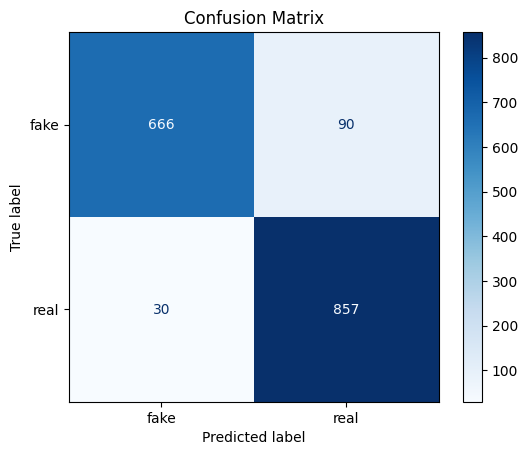

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predictions on the test set
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


# ROC Curve

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


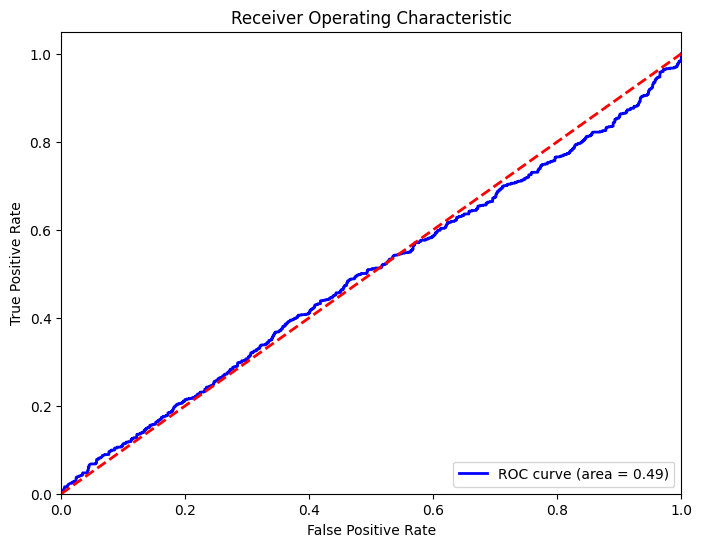

In [ ]:
from sklearn.metrics import roc_curve, auc

# One-hot encode the true labels
y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes=n_classes)

# Get predicted probabilities for the positive class (class 1)
y_score = model.predict(test_ds)
y_score = y_score[:, 1]  # Adjust for your specific class of interest

fpr, tpr, _ = roc_curve(y_true_one_hot[:, 1], y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve

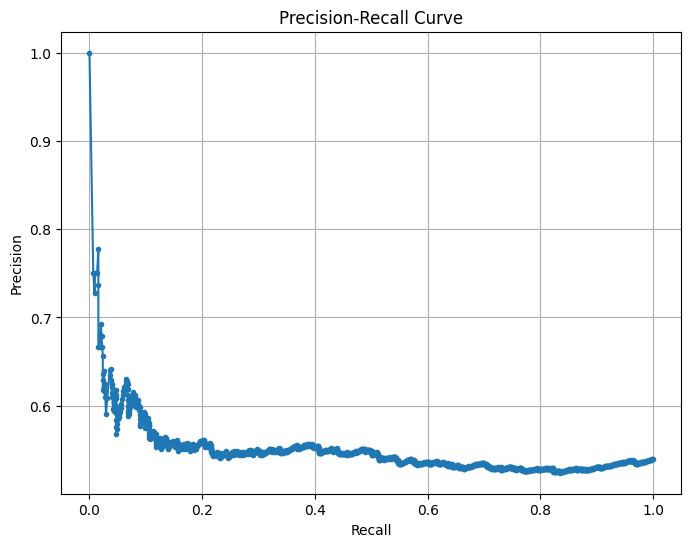

In [ ]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

precision, recall, _ = precision_recall_curve(y_true_one_hot[:, 1], y_score)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

# predicting labels for the batch of images

first image to predict
Actual label :  fake
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
Pred label :  fake


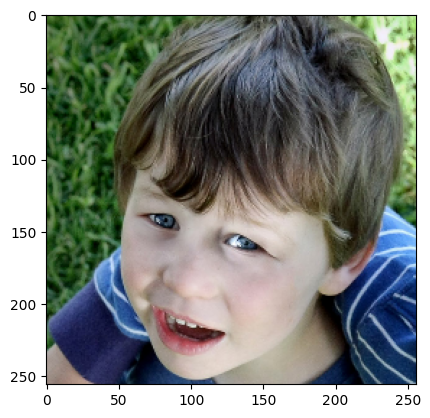

In [ ]:
import numpy as np

for image_batch, label_batch in imgdata.take(1):

    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("Actual label : ",class_names[first_label])


    batch_pred = model.predict(image_batch)
    print("Pred label : ",class_names[np.argmax(batch_pred[0])])

# image prediction function using the model


In [ ]:
def pred(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

# Displaying Sample Predictions with Confidence


In [ ]:
plt.figure(figsize=(15, 15))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = pred(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual : {actual_class},\n Predicted:{predicted_class}.\n Confidence:{confidence}%")

        plt.axis("off")

# saving the model


In [ ]:
import pickle

with open('model_f_real_pickle_final','wb') as f:
  pickle.dump(model,f)


In [ ]:
# to run the pickle(saved model)
# import pickle

with open('model_f_real_pickle_final','rb') as f:
  model_saved = pickle.load(f)

#to predict the model
#model_saved.predict("give input")

In [ ]:
# @title
plt.figure(figsize=(15, 15))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = pred(model_saved, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual : {actual_class},\n Predicted:{predicted_class}.\n Confidence:{confidence}%")

        plt.axis("off")

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def predict_image(model, img_path, class_names):
    # Load the image
    img = image.load_img(img_path, target_size=(Image_Size, Image_Size))
    img_array = image.img_to_array(img)  # Convert the image to a numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Rescale pixel values

    # Make predictions
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)

    return predicted_class, confidence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted Class: real, Confidence: 50.95%


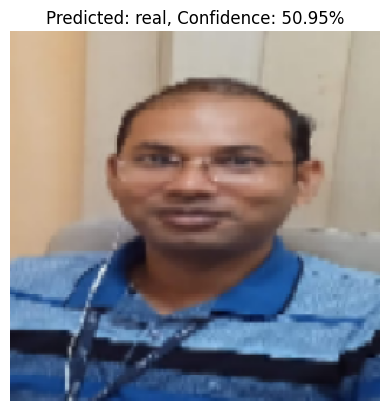

In [ ]:
# Example usage
img_path = "/content/drive/MyDrive/deepfake/Screenshot 2024-10-09 225504.png"  # Replace with the path to your image
predicted_class, confidence = predict_image(model, img_path, class_names)

print(f"Predicted Class: {predicted_class}, Confidence: {confidence}%")

# Display the image
img = image.load_img(img_path, target_size=(Image_Size, Image_Size))
plt.imshow(img)
plt.title(f"Predicted: {predicted_class}, Confidence: {confidence}%")
plt.axis('off')
plt.show()
